In [6]:
import netket as nk
import json
from qutip import *
import numpy as np
import time
import multiprocessing as mp
from collections import OrderedDict
from pickle import dump
import os
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from functools import reduce
from functools import wraps
plt.style.use('seaborn')
from scipy.stats import norm
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200

In [7]:
data = []
Eng = []
Iter = []
with open('2021_summer_data/2022_winter_data/post_selection_data/excited_Logs_N6_i1_j41.log', 'r') as f:
    for line in f:
        data.append(line)
#use string tricks to convert everything to numbers
data = data[0].replace('[','!').replace(']','!').split('!')
Iter = list(map(int, data[1].split(',')))
Eng = list(map(float, data[3].split(',')))


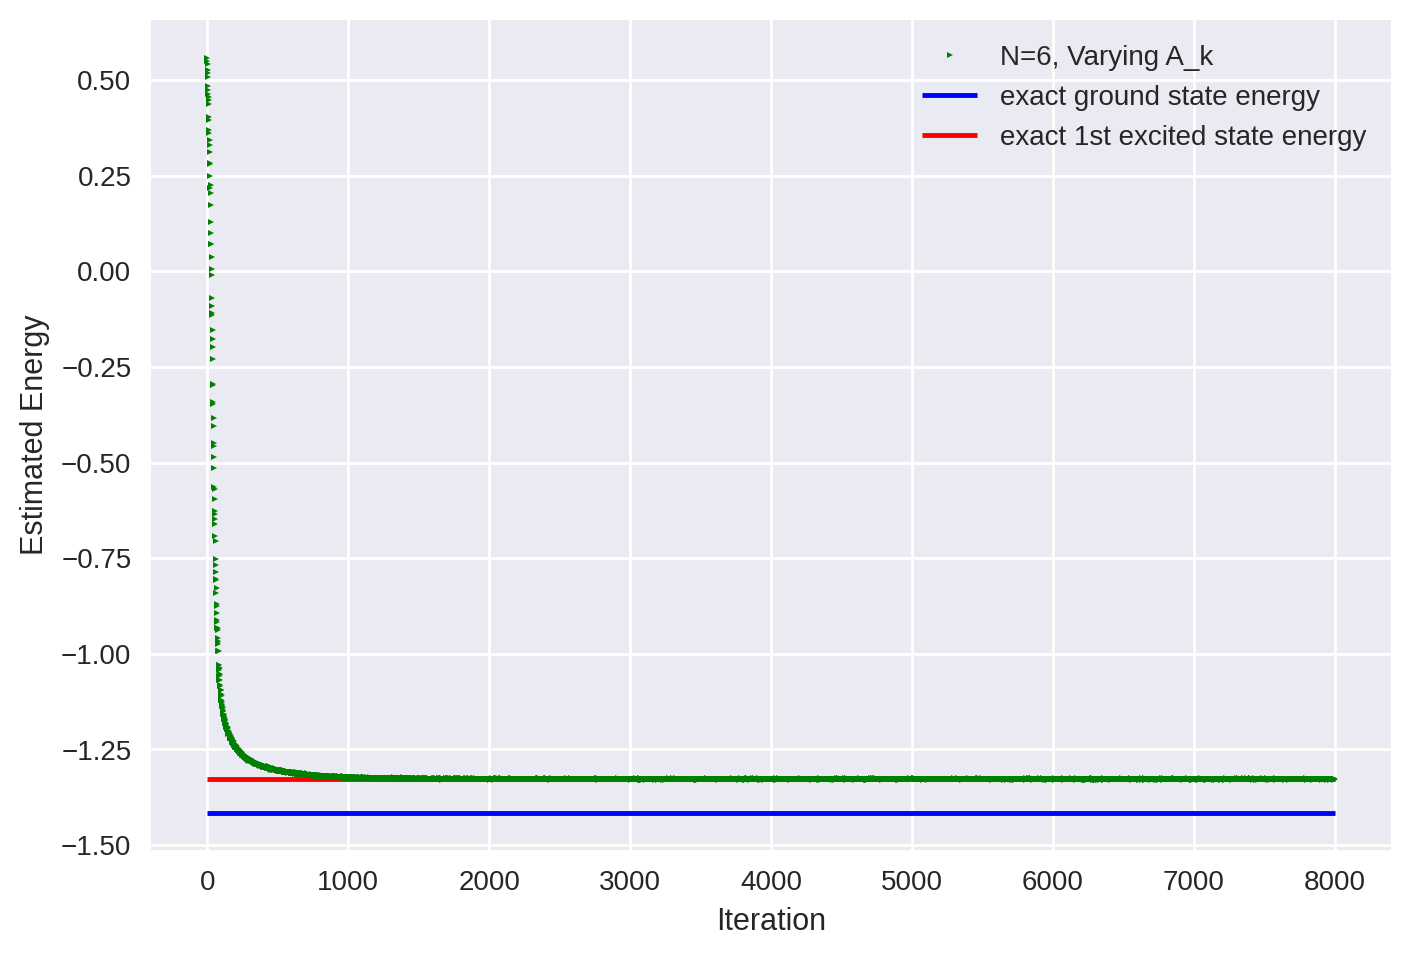

In [8]:
#finally, plot them
plt.plot(Iter,Eng,'g>',markersize=2,label='N=6, Varying A_k')
plt.hlines( -1.41524943 ,0,Iter[-1],label='exact ground state energy', color = 'b')
plt.hlines( -1.32771232 ,0,Iter[-1],label='exact 1st excited state energy', color = 'r')
#plt.hlines(-1.11089347 ,0,Iter[-1],label='higher exact energy')
#plt.hlines(-1.1127434646079892,0,Iter[-1], color='green')
plt.ylabel('Estimated Energy')
plt.xlabel('Iteration')
#plt.ylim(-1.115,-1.109)
#plt.ylim(-1.225,-1.2175)
#plt.xlim(9500, 10000)
plt.legend()
plt.show()

In [122]:
a=  np.mean(Eng[9980:10000])
print(a)

nan


In [123]:
print(np.abs(-1.19876478-a))

nan


In [44]:
#check standard error and standard deviation of the mean

se = list(map(float, data[9].replace(',null','').split(',')))
print('mean standard error of the last 500 iteratios is '+str(np.mean(se[9500:10000])))
print('standard deviation of the last 500 local energy values is '+str(np.std(Eng[9500:10000], ddof=1)))

mean standard error of the last 500 iteratios is 0.00019751064107267113
standard deviation of the last 500 local energy values is 0.00041309950962659727


In [40]:
se_list = []
std_list = []
se_std_list=[]
for i in range(12):
    i = 500*i
    se_list.append(np.mean(se[i+4000:i+4500]))
    std_list.append(np.std(Eng[i+4000:i+4500], ddof=1))
    se_std_list.append(np.std(se[i+4000:i+4500]))

print(se_std_list)

[0.00016215223209848568, 0.00014981654678910183, 0.00013513659458701946, 0.0001341145803137525, 0.0001770711890281112, 0.0001541721115795784, 0.00013080108939146322, 0.0001892040921259556, 0.00017725443353287595, 0.0001047568597284885, 0.00020048547933578542, 0.00012091106122019304]


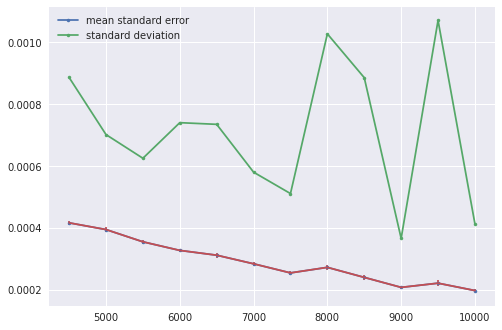

In [43]:
step = np.linspace(4500, 10000,12)
plt.plot(step, se_list, label='mean standard error', marker='.')
plt.plot(step, std_list, label= 'standard deviation', marker='.')
plt.errorbar(step, se_list, yerr = se_std_list/np.sqrt(500))
plt.legend()
plt.show()

In [95]:
# Error Calculation (Input: the found state, the state from exact diagonalization, the found energy, the energy from exact diagonalization)
def err_sta(state, edState,N):
    overlap = np.dot(state.conj().reshape(2**N, 1).T, edState.reshape(2**N, 1))
    waveFunctionErr = 1 - (np.linalg.norm(overlap))**2
    return waveFunctionErr

def state_error(state_list, ex_state_list, N):
    state_er = []
    for i in range(len(state_list)):
        state_er_temp = err_sta(state_list[i], ex_state_list[i], N)
        state_er.append(state_er_temp)
    return state_er

def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

In [96]:
N = 6
Ak = []

alpha = 1   #density of RBM
M = alpha*N
# Constant A
B = 0.95
# Variable A
A = N/2
N0 = N/2
for i in range(N-1):
    # Constant A
    #Ak_i = 1
    # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)
    
# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)


#Exact Diagonalization
e, v = exactDiagonalization_full(ha)

In [100]:
state_list = np.loadtxt('2021_summer_data/State_list/var_post_0_excited_states.json',dtype=complex)
err_list = []
for state_i in state_list:
    err_list.append(err_sta(state_i, v[0],N))
print(err_list)

[0.0016637443829283782, 0.0006897474716852647, 0.0003730292685885095, 0.0004931444289938414, 0.000603918261657399, 0.00042781774310840515, 0.00044593997452646583, 0.0010794660962063496, 0.0005239809162655984, 0.001139719641426784, 0.0008545011561191806, 0.001945932970202069, 0.09306543517347043, 0.0014577860709266144, 0.0005257741133581906, 0.00028318488519996077, 0.0015222058616511935, 0.0008886207766974907, 0.09306396352611979, 0.002119232920168579]


In [101]:
b = [0.00019659796588822331, -1.7112575483313464e-05, 0.00010533311016724944, 0.0001439102215210486, -0.00012739349363521946, 6.730167481583393e-05, 0.0006597736148095112, 9.372618785730147e-05, 0.00010265015159682811, 0.0001152327098676853, -1.0129431811112255e-06, 0.0002777822395259033, 0.22490110962415577, 0.0005958659213742834, -9.064029998717693e-05, -2.0432915124324325e-06, 0.00023969450812888482, 0.00017675358556612508, 0.22495857701380717, 0.0009280038277472702]

In [102]:
print(b)

[0.00019659796588822331, -1.7112575483313464e-05, 0.00010533311016724944, 0.0001439102215210486, -0.00012739349363521946, 6.730167481583393e-05, 0.0006597736148095112, 9.372618785730147e-05, 0.00010265015159682811, 0.0001152327098676853, -1.0129431811112255e-06, 0.0002777822395259033, 0.22490110962415577, 0.0005958659213742834, -9.064029998717693e-05, -2.0432915124324325e-06, 0.00023969450812888482, 0.00017675358556612508, 0.22495857701380717, 0.0009280038277472702]


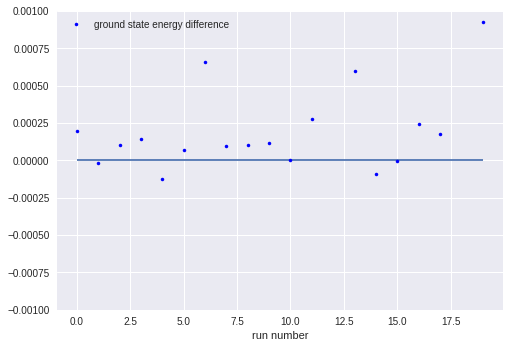

In [114]:
index = np.linspace(0,19,20)
plt.plot(index, b, 'b.', label = 'ground state energy difference')
plt.ylim(-0.001, 0.001)
plt.hlines(0,0,19)
plt.xlabel('run number')
plt.legend()
